<a href="https://colab.research.google.com/github/kiran08012002/Circle_Detection/blob/main/Circle_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install opencv-python
!pip install torch torchvision  # If using YOLOv5 or YOLOv8


In [ ]:
# Dataset Creation
# We'll generate synthetic images with circles using OpenCV.

In [13]:
import cv2
import numpy as np
import os

# Create directories for images and labels
os.makedirs('images', exist_ok=True)
os.makedirs('labels', exist_ok=True)

def create_circle_image(image_size=(512, 512), num_circles=1):
    img = np.zeros(image_size + (3,), dtype=np.uint8)
    label_data = []
    for _ in range(num_circles):
        radius = np.random.randint(10, 50)
        center = (np.random.randint(radius, image_size[0] - radius),
                  np.random.randint(radius, image_size[1] - radius))
        color = tuple(np.random.randint(0, 256, size=3).tolist())
        cv2.circle(img, center, radius, color, -1)

        # Normalize and save label (YOLO format: x_center, y_center, width, height)
        x_center, y_center = center[0] / image_size[0], center[1] / image_size[1]
        width, height = (2 * radius) / image_size[0], (2 * radius) / image_size[1]
        label_data.append([0, x_center, y_center, width, height])

    return img, label_data

# Generate a dataset of 100 images
for i in range(100):
    img, labels = create_circle_image()
    img_path = f'images/img_{i}.jpg'
    label_path = f'labels/img_{i}.txt'

    cv2.imwrite(img_path, img)
    with open(label_path, 'w') as f:
        for label in labels:
            f.write(' '.join(map(str, label)) + '\n')


In [15]:
# Create Negative Examples:
def create_negative_image(image_size=(512, 512)):
    img = np.random.randint(0, 256, image_size + (3,), dtype=np.uint8)
    return img

# Generate 20 negative images
for i in range(100, 120):
    img = create_negative_image()
    img_path = f'images/img_{i}.jpg'
    cv2.imwrite(img_path, img)
    open(f'labels/img_{i}.txt', 'w').close()  # Empty label file


In [ ]:
# Model Training
# Clone YOLOv5 Repository:

In [1]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [ ]:
# Prepare Dataset Configuration:
# Create a YAML file (e.g., circles.yaml) to define the dataset paths:

In [2]:
# Define the content of the YAML file
yaml_content = """
train: ../images  # Path to the training images
val: ../images  # Path to the validation images

nc: 1  # Number of classes (in this case, 1 because we're only detecting circles)
names: ['circle']  # List of class names (in this case, just 'circle')
"""

# Write the content to a file named 'circles.yaml'
with open('circles.yaml', 'w') as file:
    file.write(yaml_content)


In [4]:
# Train the Model:
!python train.py --img 512 --batch 16 --epochs 50 --data circles.yaml --cfg yolov5s.yaml --weights yolov5s.pt --name circle_detect

2024-08-13 06:34:51.029860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 06:34:51.385224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 06:34:51.476449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=circles.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_c

In [20]:
# Model Evaluation
# After training, evaluate the model on the test set and calculate metrics like accuracy, precision, recall, and IoU.
!python val.py --weights runs/train/circle_detect/weights/best.pt --data circles.yaml --img 512

val: data=circles.yaml, weights=['runs/train/circle_detect/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-351-g19ce9029 Python-3.10.12 torch-2.3.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/labels... 100 images, 1 backgrounds, 0 corrupt: 100% 101/101 [00:00<00:00, 1139.00it/s]
val: New cache created: /content/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:57<00:00, 14.41s/it]
                   all        101        100      0.999          1      0.995      0.849
Speed: 10.1ms pre-process, 547.9ms inference, 3.9ms NMS per image at shape (32, 3, 512, 512)
Results saved to

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-351-g19ce9029 Python-3.10.12 torch-2.3.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


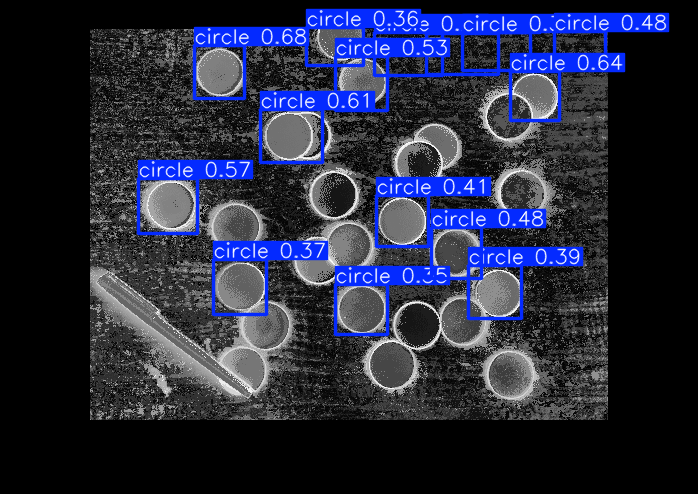

In [16]:
# Visualize some test results:
# Import necessary libraries
import torch
from utils.plots import plot_images
from utils.general import xyxy2xywh

# Load the trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='runs/train/circle_detect/weights/best.pt')

# Path to the test image
img = '/content/images/circle.png'

# Run the model on the test image
results = model(img)

# Show the results
results.show()


In [ ]:
# You can also display one of the generated images to see what it looks like:

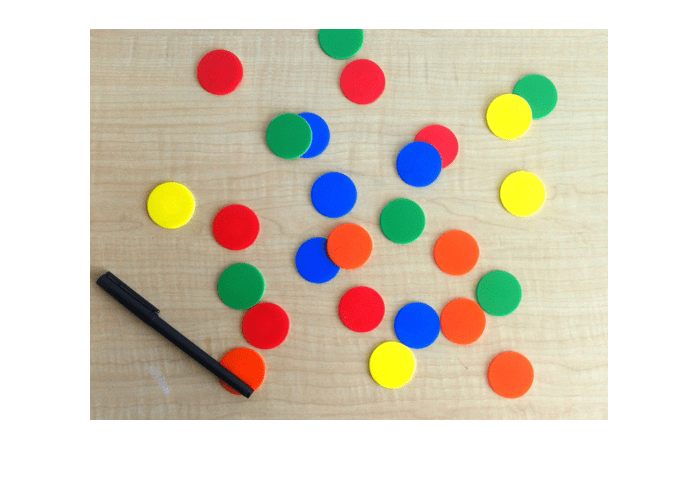

In [18]:
from IPython.display import Image, display

display(Image(filename='/content/images/circle.png'))
